In [3]:
import nilearn #this is the library we are gonna be using
import warnings
warnings.filterwarnings("ignore")

In [4]:
#then we are fetching the data from the abide dataset with the qualifications we choose
from nilearn.datasets import fetch_abide_pcp
abide = fetch_abide_pcp(derivatives = ['func_preproc'], pipeline = 'cpac', quality_checked = True)
# Variables Used Fetching the Data:
# •	 Derivatives = Preprocessed data
# • Pipeline = CPAC (motion correction, slice timing, normalization to MNI space. nuisance regression)
# •	Quality Checked = True (only the good quality data is collected in the dataset)

[get_dataset_dir] Dataset found in C:\Users\mutlu\nilearn_data\ABIDE_pcp

In [5]:
from nilearn import datasets
import numpy as np

# Load Schaefer atlas (200 ROIs, 7-networks)
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
atlas_maps = atlas['maps']
atlas_labels = atlas['labels']

# Pick ROIs related to Default Mode Network
wanted_keywords = ['PFCmp', 'pCunPCC', 'Default_Par']  #this is the regions we want to use 
target_indices = [i + 1 for i, label in enumerate(atlas_labels)
                  if any(w in label.decode('utf-8') for w in wanted_keywords)]
roi_indices = np.array(target_indices) - 1  # adjust for Python 0-based indexing

[get_dataset_dir] Dataset found in C:\Users\mutlu\nilearn_data\schaefer_2018

In [6]:
print(roi_indices)

[ 78  79  80  81  95  96  97  98 179 180 181 182 183 197 198 199]


In [7]:
import numpy as np

# Load the saved ASD connectivity matrices
asd_matrices = np.load("connectivity_matrices_asd.npy")
control_matrices = np.load("connectivity_matrices_control.npy")

# Check the shape to confirm it loaded correctly
print(asd_matrices.shape)
print(control_matrices.shape)

(403, 120)
(468, 120)


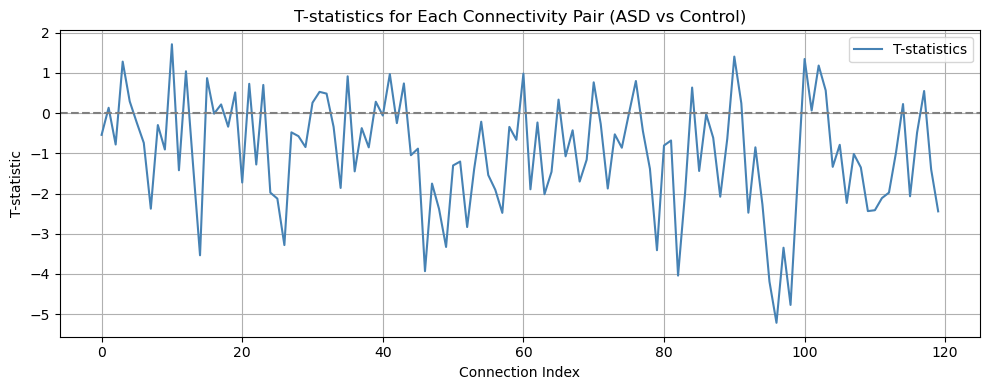

In [8]:
import numpy as np

from scipy.stats import ttest_ind
# Welch's t-test is used because The subject numebers are different 
# Equal_var = False to specify the difference
t_stats, p_val = ttest_ind(asd_matrices, control_matrices, equal_var=False)


# t-test value for each of the roi x roi
# t = asd means - control means / standart error
# which means:
# positive values = asd > control
#negative values = asd < control

import matplotlib.pyplot as plt
# Visualizing the t-statistics
plt.figure(figsize=(10, 4))  # figure size width = 20, height = 4 units
plt.plot(t_stats, label="T-statistics", color='steelblue') # plotting the t-test
plt.axhline(0, color='gray', linestyle='--') 
plt.title("T-statistics for Each Connectivity Pair (ASD vs Control)")
plt.xlabel("Connection Index")
plt.ylabel("T-statistic")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [9]:
import numpy as np

#finding the max and min index to see the peak max, min
max_idx = np.argmax(t_stats)  # ASD > Control
min_idx = np.argmin(t_stats)  # Control > ASD

# The values of the peak max and min
print(f" Peak positive t-statistic at index {max_idx}: t = {t_stats[max_idx]:.3f}")
print(f" Peak negative t-statistic at index {min_idx}: t = {t_stats[min_idx]:.3f}")


 Peak positive t-statistic at index 10: t = 1.709
 Peak negative t-statistic at index 96: t = -5.213


In [10]:
import numpy as np
from nilearn import datasets

# Load the Schaefer 200 ROI atlas
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
atlas_labels = atlas['labels']

# Step 1: Filter ROIs of interest by keywords
wanted_keywords = ['PFCmp', 'pCunPCC', 'Default_Par']
target_indices = [i for i, label in enumerate(atlas_labels)
                  if any(w in label.decode('utf-8') for w in wanted_keywords)]

# Step 2: Get region labels
roi_labels = [atlas_labels[i].decode('utf-8') for i in target_indices]

# Step 3: Compute upper triangle index map for connectivity vector
n_rois = len(roi_labels)
triu_i, triu_j = np.triu_indices(n_rois, k=1)

# Step 4: Function to return label and full index
def get_roi_pair_from_index(index):
    local_i = triu_i[index]
    local_j = triu_j[index]
    
    full_i = target_indices[local_i]
    full_j = target_indices[local_j]

    label_i = atlas_labels[full_i].decode('utf-8')
    label_j = atlas_labels[full_j].decode('utf-8')

    print(
          f"ROI {full_i} → {label_i}\n"
          f"ROI {full_j} → {label_j}\n")
    
    return (full_i, label_i), (full_j, label_j)

[get_dataset_dir] Dataset found in C:\Users\mutlu\nilearn_data\schaefer_2018

In [ ]:
import numpy as np
import matplotlib.pyplot as plt #plotting library
from sklearn.svm import SVC   #the library suport vector classification

X = np.vstack((asd_matrices, control_matrices))  # shape: (871, 120) for all of the connectivity values
print(X.shape)
#extracting only hypoconnected indexes for training
hypo_indices = [96, 98, 95, 82, 46]
X_hypo = X[:, hypo_indices]  # shape: (871, 5)  


y = np.array([1]*403 + [0]*468)  # shape: (871,) to see if its control or asd



In [19]:
from sklearn.model_selection import train_test_split
#train_test_split for splitting the dataset into training and splitting parts 

# 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X_hypo,    #hypo conn indexes only
    y,         # asd or control
    test_size=0.2,   # %20 of the data will be used for testing
    random_state=42, #making sure the seed is the same to avoid new results each time
    stratify=y
)

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scaler", StandardScaler()),  
    ("svc", SVC()) #our machine learning model: support vector classifier
])

#Scaler in this case helps us to standartize our data, if the differences betweeen data is too much, the result can be unstable 
# the formula that is used for the standartization is : (orginal value - mean) / standart deviation

In [21]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Applying Stratified 5-Fold Cross-Validation to split the data into 5 parts 
# while keeping the ASD/Control ratio the same in each fold.
# This helps avoid bias and provides more stable, accurate model training and evaluation.


In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint

#scoring elemtns we will be needed and shown at the end
scoring = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1_macro": "f1_macro",
    "f1_weighted": "f1_weighted",
    "precision_weighted": "precision_weighted",
    "recall_weighted": "recall_weighted",
}


search_linear = RandomizedSearchCV(
    estimator=pipe,                      #the pipeline used for each search
        param_distributions={
        "svc__kernel": ["linear"],
        "svc__C": loguniform(1e-3, 1e3),
        "svc__class_weight": [None, "balanced"]
    },                                    #the parameters are tested one by one
    n_iter= 20,                           # 80 iteration will take place
    scoring=scoring,                     # scoring will be evaluated with the scopring titles we just defined
    refit="f1_weighted",                 #the best fit will be found by using f1 weighted result
    n_jobs= -1,                           #for faster evaluation
    cv=cv,                               # using the defined cross vector validation
    random_state=42,                     # randomizing seed for future check
    verbose=2,                           # printing process info
    return_train_score=False             # not saving each score
)


search_linear.fit(X_train, y_train)

print("Linear:", search_linear.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Linear: 0.5514632247048944


✅ Accuracy: 0.58

🧾 Confusion Matrix:
 [[69 25]
 [49 32]]


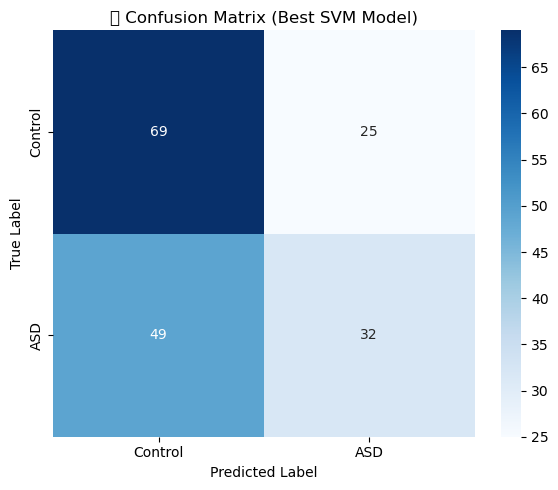


📊 Classification Report:
               precision    recall  f1-score   support

     Control       0.58      0.73      0.65        94
         ASD       0.56      0.40      0.46        81

    accuracy                           0.58       175
   macro avg       0.57      0.56      0.56       175
weighted avg       0.57      0.58      0.56       175



In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict using the best model found
best_model = search_linear.best_estimator_      # Get the best pipeline
y_pred = best_model.predict(X_test)  # Use it to predict on test set

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n🧾 Confusion Matrix:\n", cm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Control", "ASD"], yticklabels=["Control", "ASD"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🧠 Confusion Matrix (Best SVM Model)")
plt.tight_layout()
plt.show()

# Detailed classification report
report = classification_report(y_test, y_pred, target_names=["Control", "ASD"])
print("\n📊 Classification Report:\n", report)


In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint

#scoring elemtns we will be needed and shown at the end
scoring = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1_macro": "f1_macro",
    "f1_weighted": "f1_weighted",
    "precision_weighted": "precision_weighted",
    "recall_weighted": "recall_weighted",
}


search_rbf = RandomizedSearchCV(
    estimator=pipe,                      #the pipeline used for each search
    param_distributions = {"svc__kernel": ["rbf"],
     "svc__C": loguniform(1e-3, 1e3), 
     "svc__gamma": loguniform(1e-4, 1e1),
     "svc__class_weight": [None, "balanced"]},                                    
    n_iter= 20,                           # 80 iteration will take place
    scoring=scoring,                     # scoring will be evaluated with the scopring titles we just defined
    refit="f1_weighted",                 #the best fit will be found by using f1 weighted result
    n_jobs= -1,                           #for faster evaluation
    cv=cv,                               # using the defined cross vector validation
    random_state=42,                     # randomizing seed for future check
    verbose=2,                           # printing process info
    return_train_score=False             # not saving each score
)


search_rbf.fit(X_train, y_train)

print("Rbf:", search_rbf.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Rbf: 0.5473438504398888


✅ Accuracy: 0.58

🧾 Confusion Matrix:
 [[71 23]
 [50 31]]


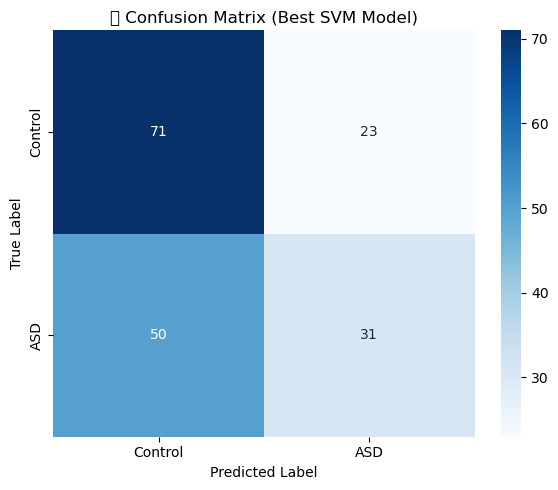


📊 Classification Report:
               precision    recall  f1-score   support

     Control       0.59      0.76      0.66        94
         ASD       0.57      0.38      0.46        81

    accuracy                           0.58       175
   macro avg       0.58      0.57      0.56       175
weighted avg       0.58      0.58      0.57       175



In [26]:

# Predict using the best model found
best_model = search_rbf.best_estimator_      # Get the best pipeline
y_pred = best_model.predict(X_test)  # Use it to predict on test set

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n🧾 Confusion Matrix:\n", cm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Control", "ASD"], yticklabels=["Control", "ASD"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🧠 Confusion Matrix (Best SVM Model)")
plt.tight_layout()
plt.show()

# Detailed classification report
report = classification_report(y_test, y_pred, target_names=["Control", "ASD"])
print("\n📊 Classification Report:\n", report)

In [ ]:
# Define RandomizedSearchCV for the polynomial kernel
search_poly = RandomizedSearchCV(
    estimator=pipe,  # your pipeline (e.g., includes StandardScaler + SVC)

    param_distributions={
        "svc__kernel": ["poly"],                      # only test polynomial kernel
        "svc__C": loguniform(1e-3, 1e3),               # regularization strength
        "svc__gamma": loguniform(1e-4, 1e1),           # kernel coefficient
        "svc__degree": randint(2, 7),                  # polynomial degree (e.g., 2 to 6)
        "svc__class_weight": [None, "balanced"]       # handle class imbalance
    },

    n_iter=20,                      # try 20 random combinations
    scoring=scoring,               # multiple scoring metrics
    refit="f1_weighted",           # final model chosen by best f1_weighted
    n_jobs=-1,                     # use all processors
    cv=cv,                         # 5-fold stratified cross-validation
    random_state=42,               # reproducibility
    verbose=2,                     # print progress
    return_train_score=False       # don’t keep training scores
)

# Fit the model
search_poly.fit(X_train, y_train)

# Show the best weighted F1-score from cross-validation
print("✅ Best F1-weighted score (poly kernel):", search_poly.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:

# Predict using the best model found
best_model = search_poly.best_estimator_      # Get the best pipeline
y_pred = best_model.predict(X_test)  # Use it to predict on test set

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n🧾 Confusion Matrix:\n", cm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Control", "ASD"], yticklabels=["Control", "ASD"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🧠 Confusion Matrix (Best SVM Model)")
plt.tight_layout()
plt.show()

# Detailed classification report
report = classification_report(y_test, y_pred, target_names=["Control", "ASD"])
print("\n📊 Classification Report:\n", report)

In [16]:

    {"svc__kernel": ["sigmoid"], 
     "svc__C": loguniform(1e-3, 1e3), 
     "svc__gamma": loguniform(1e-4, 1e1),
     "svc__class_weight": [None, "balanced"]},

In [19]:
from sklearn.model_selection import RandomizedSearchCV


# RandomizedSearchCV is used to tune the model by searching for the best combination of hyperparameters.
# Instead of trying every possible combination (like GridSearchCV), it randomly tries a set number of combinations.
# This makes the process faster while still giving strong results.

rs = RandomizedSearchCV(
    estimator=pipe,                      #the pipeline used for each search
    param_distributions=search_spaces,   #the parameters are tested one by one
    n_iter=80,                           # 80 iteration will take place
    scoring=scoring,                     # scoring will be evaluated with the scopring titles we just defined
    refit="f1_weighted",                 #the best fit will be found by using f1 weighted result
    n_jobs= -1,                           #for faster evaluation
    cv=cv,                               # using the defined cross vector validation
    random_state=42,                     # randomizing seed for future check
    verbose=2,                           # printing process info
    return_train_score=False             # not saving each score
)

In [ ]:
#training the data with wanted qualifications
rs.fit(X_train, y_train)
print("✅ Training complete!")

Fitting 5 folds for each of 80 candidates, totalling 400 fits


In [ ]:
cv_results = pd.DataFrame(rs.cv_results_)
metric_cols = [
    "mean_test_accuracy", "mean_test_balanced_accuracy", "mean_test_f1_macro",
    "mean_test_f1_weighted", "mean_test_precision_weighted", "mean_test_recall_weighted",
    "mean_test_roc_auc_ovr"
]

In [ ]:



param_cols = [c for c in cv_results.columns if c.startswith("param_")]

summary = cv_results[["rank_test_f1_weighted"] + metric_cols + param_cols] \
    .sort_values("rank_test_f1_weighted")

print("Best params (by f1_weighted):", rs.best_params_)
print("Best CV f1_weighted:", rs.cv_results_["mean_test_f1_weighted"][rs.best_index_])
print("\nTop 10 models:\n", summary.head(10).to_string(index=False))

# -------------------------
# Step 5: Test set evaluation
# -------------------------
best_model = rs.best_estimator_
y_pred = best_model.predict(X_test)

print("\nTest metrics:")
print("accuracy:           ", accuracy_score(y_test, y_pred))
print("balanced_accuracy:  ", balanced_accuracy_score(y_test, y_pred))
print("f1_macro:           ", f1_score(y_test, y_pred, average="macro"))
print("f1_weighted:        ", f1_score(y_test, y_pred, average="weighted"))
print("precision_weighted: ", precision_score(y_test, y_pred, average="weighted", zero_division=0))
print("recall_weighted:    ", recall_score(y_test, y_pred, average="weighted"))

# Optional: ROC-AUC on test set
y_score = best_model.decision_function(X_test)
try:
    auc_test = roc_auc_score(y_test, y_score, multi_class="ovr")
    print("roc_auc_ovr:        ", auc_test)
except ValueError as e:
    print("roc_auc_ovr:        N/A (", e, ")")

# -------------------------
# Step 6: Confusion Matrix
# -------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Control", "ASD"], yticklabels=["Control", "ASD"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Best SVM Model")
plt.tight_layout()
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [21]:
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

# Training part
clf = SVC(kernel='linear', C=1)  #c is for margin: higher c is more prone to overfitting
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)



✅ Accuracy: 0.58

🧾 Confusion Matrix:
 [[85  9]
 [64 17]]


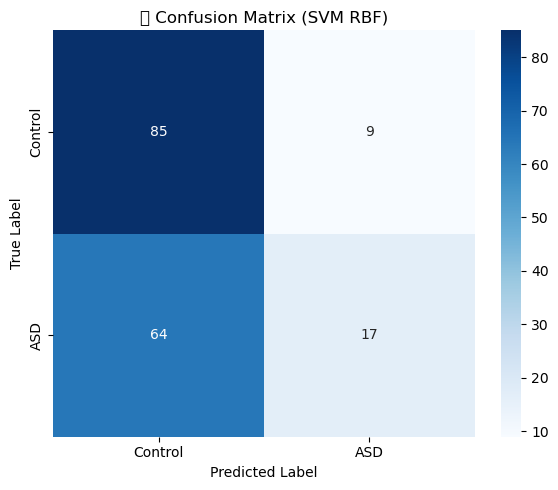


📊 Classification Report:
               precision    recall  f1-score   support

     Control       0.57      0.90      0.70        94
         ASD       0.65      0.21      0.32        81

    accuracy                           0.58       175
   macro avg       0.61      0.56      0.51       175
weighted avg       0.61      0.58      0.52       175



In [22]:

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n🧾 Confusion Matrix:\n", cm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Control", "ASD"], yticklabels=["Control", "ASD"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🧠 Confusion Matrix (SVM RBF)")
plt.tight_layout()
plt.show()


# Detailed report
report = classification_report(y_test, y_pred, target_names=["Control", "ASD"])
print("\n📊 Classification Report:\n", report)

In [15]:
for C_val in [0.01, 0.1, 1, 10, 100]:
    clf = SVC(kernel='linear', C=C_val)
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    print(f"C={C_val:<6} → Accuracy: {acc:.3f}")

C=0.01   → Accuracy: 0.537
C=0.1    → Accuracy: 0.537
C=1      → Accuracy: 0.583
C=10     → Accuracy: 0.589
C=100    → Accuracy: 0.589


✅ RBF Kernel Accuracy: 0.60

🧾 Confusion Matrix (RBF):
 [[87  7]
 [63 18]]


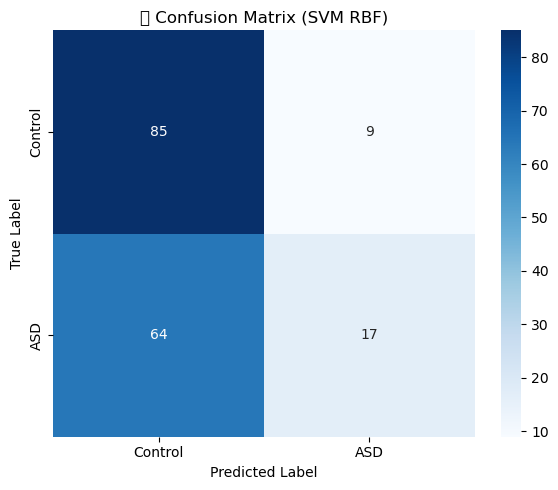


📊 Classification Report (RBF):
               precision    recall  f1-score   support

     Control       0.58      0.93      0.71        94
         ASD       0.72      0.22      0.34        81

    accuracy                           0.60       175
   macro avg       0.65      0.57      0.53       175
weighted avg       0.64      0.60      0.54       175



In [16]:

clf_rbf = SVC(kernel='rbf', C=1, gamma='scale')  # gamma controls how far each training example "reaches" to affect the decision boundary.

clf_rbf.fit(X_train, y_train)

y_pred_rbf = clf_rbf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Accuracy
print(f"✅ RBF Kernel Accuracy: {accuracy_score(y_test, y_pred_rbf):.2f}")

# Confusion Matrix
print("\n🧾 Confusion Matrix (RBF):\n", confusion_matrix(y_test, y_pred_rbf))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Control", "ASD"], yticklabels=["Control", "ASD"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🧠 Confusion Matrix (SVM RBF)")
plt.tight_layout()
plt.show()


# Classification Report
print("\n📊 Classification Report (RBF):\n", classification_report(y_test, y_pred_rbf, target_names=["Control", "ASD"]))


In [17]:
for C_val in [0.01, 0.1, 1, 10, 100]:
    clf = SVC(kernel='rbf', C=C_val, gamma='scale')
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    print(f"C={C_val:<6} → Accuracy: {acc:.3f}")

C=0.01   → Accuracy: 0.537
C=0.1    → Accuracy: 0.583
C=1      → Accuracy: 0.600
C=10     → Accuracy: 0.606
C=100    → Accuracy: 0.549


In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[85  9]
 [64 17]]


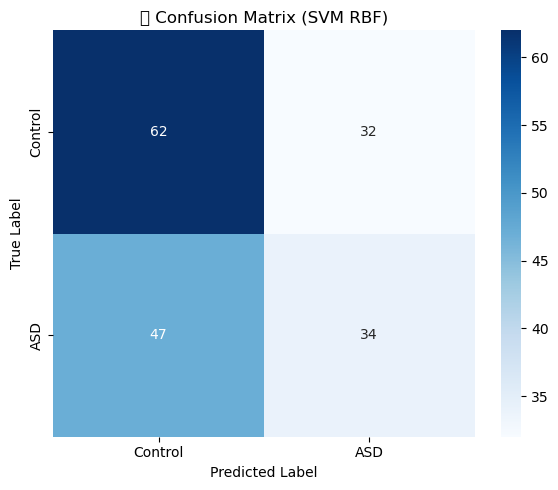

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


y_pred = clf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Control", "ASD"], yticklabels=["Control", "ASD"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🧠 Confusion Matrix (SVM RBF)")
plt.tight_layout()
plt.show()
